# PREPROCESSING

In [155]:
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import parselmouth 
from parselmouth.praat import call
import cmudict
import regex as re
import ffmpeg
import math
import dtale
import shutil
from scipy.special import eval_legendre
import scipy.stats
import statistics
import tgt
nltk.download('cmudict')
plus = pd.read_csv('mustard++_text.csv')

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\kasia\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [156]:
# remove useless stuff
plus = plus[plus['Sarcasm'].notna()] #keeps utterances
pd.set_option('display.max_colwidth', None)
plus['wrd_count'] = plus['SENTENCE'].astype(str).apply(lambda x: len(x.split())) # determine max word count
plus = plus[plus['wrd_count'] <= 20] #max word count 
plus.loc[plus['SENTENCE'].str.contains('?', regex=False), 'QUESTION?'] = True #is this utterance a Q?
plus['QUESTION?'] = plus['QUESTION?'].fillna(False)
plus = plus.infer_objects(copy=False)
plus['Sarcasm'] = plus['Sarcasm'].astype(bool)
plus = plus[plus['SCENE'] != '1_1001']
plus['SCENE'] = plus['SCENE'].astype(str) + '_u' 
plus = plus.drop(columns=['KEY','Sarcasm_Type', 'END_TIME','Implicit_Emotion','Explicit_Emotion','Valence','Arousal', 'SENTENCE'])
spee = ['RAJ', 'DINESH', 'MODERATOR', 'MEMBER-GIRL','MEMBER-BOY'] #removes non american accents
plus = plus[~plus['SPEAKER'].isin(spee)]
plus.loc[plus['SCENE'] == '2_55_u', ['SPEAKER']] = 'SHELDON'
plus = plus.reset_index()

C:\Users\kasia\AppData\Local\Temp\ipykernel_8448\1401187672.py:7: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [157]:
plus = plus.drop(columns=['index'])

In [158]:
# add gender label
man = [
    '1_4639_u','1_4789_u','1_7494_u','1_7504_u',
    '1_7953_u','1_8136_u','1_9963_u','1_11051_u',
    '1_11885_u','2_55_u','2_150_u','2_193_u','2_228_u',
    '2_245_u','2_278_u','2_295_u','2_341_u','2_415_u',
    '2_530_u','2_548_u','2_609_u','2_627_u','1_6645_u',
    '2_42_u','1_S10E01_225_u','1_S11E08_351_u','1_S12E02_274_u',
    '1_S12E04_204_u','1_S12E04_233_u','1_S12E11_072_u','1_S12E20_378_u',
    '3_S01E02_461_u','3_S01E04_327_u'
]
men = [
    'SHELDON','HOWARD','LEONARD','STUART',
    'CHANDLER','JOEY','ROSS','GILFOYLE',
    'RICHARD','ERLICH'
]
meeen = plus["SCENE"].isin(man) | plus["SPEAKER"].isin(men)
print(meeen.value_counts())
plus["GENDER"] = meeen.map({True: "M", False: "F"})

True     624
False    399
Name: count, dtype: int64


In [159]:
# how long is this? expected: 1023
print(len(plus))

1023


In [160]:
what = plus[plus['SCENE'].str.contains("1_S12E23_539")]
what

,SCENE,SPEAKER,SHOW,Sarcasm,wrd_count,QUESTION?,GENDER
581,1_S12E23_539_u,HOWARD,BBT,True,4,True,M


In [161]:
#removes rows w/o audio
root_folder = r"C:\Users\kasia\asp2025\textgrids"
wav_files = []
for dirpath, _, filenames in os.walk(root_folder):
    for f in filenames:
        if f.lower().endswith(".wav"):
            wav_files.append(f)

wav_set = set(wav_files)
wav_set = {os.path.splitext(f)[0] for f in wav_set}
plus = plus[plus["SCENE"].str.strip().isin(wav_set)]
plus = plus.reset_index()

In [162]:
# how many utterances? expected:878
print(len(plus)) 

878


In [163]:
#adds sarcasm type labels
all_1 = []
df = pd.read_csv('data_w_type.csv')
ones = df[df['TYPE'] == 1]

for idx, key in ones['SCENE'].items():
    scene = df.loc[idx, 'SCENE']
    all_1.append(scene)
    #print(scene)
#print(all_1)

for idx, key in plus['SCENE'].items():
    scene_true = plus.loc[idx, 'SCENE']
    if scene_true in all_1:
        plus.loc[idx, 'TYPE'] = 1

##############################################################################
all_2 = []
df = pd.read_csv('data_w_type.csv')
twos = df[df['TYPE'] == 2]

for idx, key in twos['SCENE'].items():
    scene = df.loc[idx, 'SCENE']
    all_2.append(scene)
    #print(scene)
#print(all_1)

for idx, key in plus['SCENE'].items():
    scene_true = plus.loc[idx, 'SCENE']
    if scene_true in all_2:
        plus.loc[idx, 'TYPE'] = 2
#############################################################################
all_3 = []
df = pd.read_csv('data_w_type.csv')
threes = df[df['TYPE'] == 3]

for idx, key in threes['SCENE'].items():
    scene = df.loc[idx, 'SCENE']
    all_3.append(scene)
    #print(scene)
#print(all_1)

for idx, key in plus['SCENE'].items():
    scene_true = plus.loc[idx, 'SCENE']
    if scene_true in all_3:
        plus.loc[idx, 'TYPE'] = 3

plus['TYPE'] = plus['TYPE'].fillna(0)
plus.head()      

,index,SCENE,SPEAKER,SHOW,Sarcasm,wrd_count,QUESTION?,GENDER,TYPE
0,0,1_10004_u,SHELDON,BBT,False,14,True,M,0.0
1,1,1_10009_u,PENNY,BBT,False,11,True,F,0.0
2,2,1_10495_u,AMY,BBT,True,19,False,F,1.0
3,3,1_105_u,SHELDON,BBT,True,20,False,M,3.0
4,4,1_10748_u,AMY,BBT,True,15,False,F,1.0


In [164]:
plus['TRANSCRIPT'] = None
base_dir = r'C:\Users\kasia\asp2025\textgrids'

for idx, key in plus['SCENE'].items():
    try:
        path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.txt"
            if target_file in files:
                path = os.path.join(root, target_file)
                break

        if path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")

        with open(path, 'r') as file:
            text = file.read()
            plus.loc[idx, 'TRANSCRIPT'] = text

    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")


In [165]:
#count num files in folder expected: 2634
file_count = sum(len(files) for _, _, files in os.walk(r'C:\Users\kasia\asp2025\textgrids'))
print(file_count)


2634


# GRAPHS

<Axes: xlabel='SPEAKER', ylabel='count'>

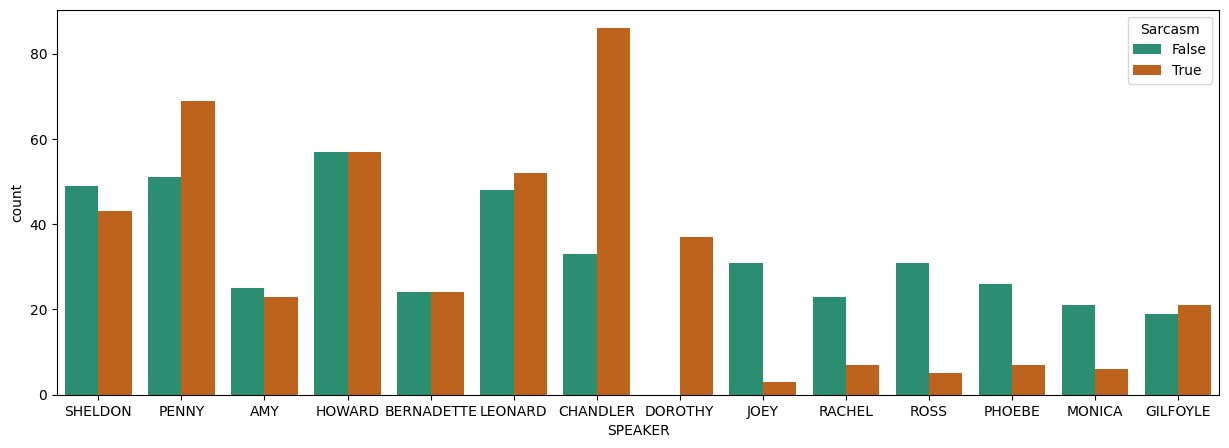

In [166]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="SPEAKER", hue="Sarcasm", palette="Dark2")

<Axes: xlabel='SPEAKER', ylabel='count'>

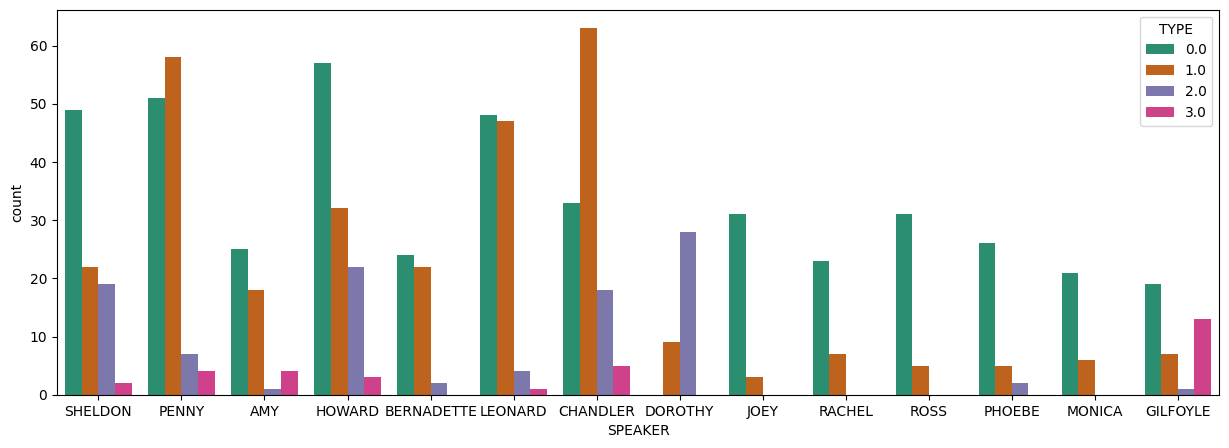

In [167]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="SPEAKER", hue="TYPE", palette="Dark2")

2025-12-22 19:00:20,087 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-22 19:00:20,094 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='TYPE', ylabel='count'>

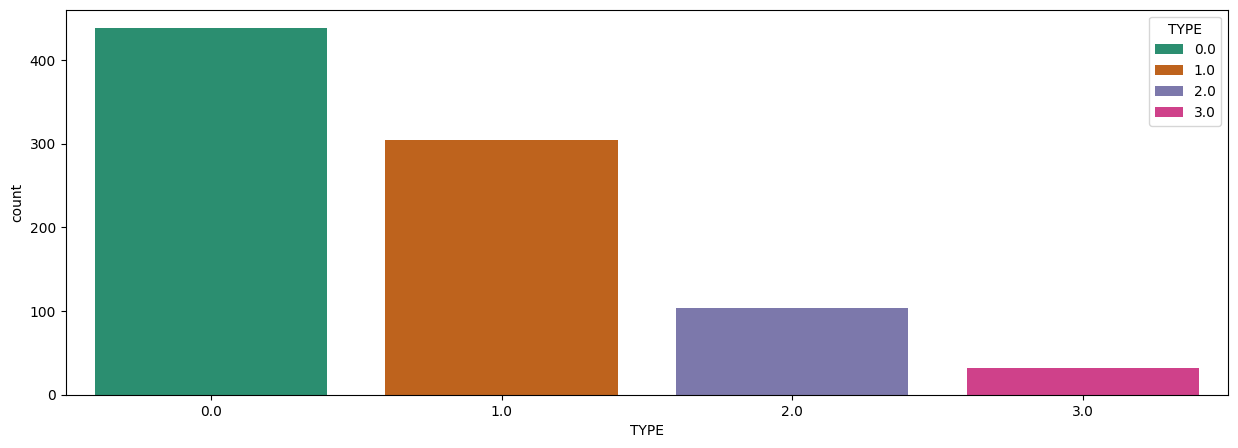

In [168]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="TYPE", hue = "TYPE",palette="Dark2")

# GLOBAL FEATURES

## PITCH AND INTENSITY FEATURES

In [169]:
base_dir = r'C:\Users\kasia\asp2025\textgrids'

In [170]:
plus['mean_F0'] = None
plus['range_F0'] = None
plus['sd_F0'] = None
plus['mean_db_z'] = None
plus['range_db_z'] = None
plus['sd_db_z'] = None
plus['duration']= None

In [171]:
def findDuration(sound):
    duration = call(sound, "Get total duration")
    return duration

In [172]:
# Get intensity and pitch contours
def get_contours(sound, start_time, end_time, keep_zeros):
    """
    Extract F0 and intensity contours from wav file, within a given time frame
    :param wav_path: Full path to a single wav file
    :param keep_zeros: True if you want to keep zeros of F0 contour (i.e., keep spaces without an F0 measurement)
    :return: the F0 and intensity contours as lists
    """
    sound_interval = sound.extract_part(from_time=start_time, to_time=end_time)
    try: # This deals with if the extracted part is shorter than the window length
        pitch_contour = sound_interval.to_pitch().interpolate().selected_array['frequency']
        #pitch_contour = sound_interval.to_pitch().selected_array['frequency']
        intensity_contour = sound_interval.to_intensity().values[0]
    except parselmouth.PraatError:
        intensity_contour = [np.nan, np.nan] # this is of length 2 just to avoid errors from statistics functions
        pitch_contour = [np.nan, np.nan]
    if not keep_zeros:
        pitch_contour = [i for i in pitch_contour if i !=0]

    if len(pitch_contour) < 2:
        pitch_contour = [np.nan, np.nan]
    if len(intensity_contour) <2:
        intensity_contour = [np.nan, np.nan]

    return pitch_contour, intensity_contour

# Convert hz to semitones
def f2st(f0_contour,reference_f0):
    """
    Convert Hz to Semitones. Used for Speaker Normalization
    :param f0_contour: list of F0 values
    :param reference_f0: In the case of speaker normalization, this is the mean F0 of the speaker
    :return: List of F0 values in semitones
    """
    return [12*math.log(i/reference_f0,2) for i in f0_contour]

# Convert db to z-scores
def norm_intensity(intensity_contour):
    """
    Conver dB to z-scores. Used for speaker normalization
    :param intensity_contour: Intensity values in dB
    :return: intensity contours in z-scores
    """
    return scipy.stats.zscore(intensity_contour)

def get_mean(contour):
    return statistics.mean(contour)

def get_range(contour):
    return max(contour) - min(contour)

def get_sd(contour):
    return statistics.stdev(contour)



In [173]:
plus['mean_db'] = None
plus['sd_db'] = None
plus['intensity_contour'] = None
plus['intensity_contour'] = plus['intensity_contour'].astype(object)
for idx, key in plus['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")

        sound = parselmouth.Sound(wav_path)
        
        duration = findDuration(sound)
        pitch_contour, intensity_contour = get_contours(sound, 0.0, duration, keep_zeros=False)
        mean_F0 = get_mean(pitch_contour)
        range_F0 = get_range(pitch_contour)
        sd_F0 = get_sd(pitch_contour)
        ###################################
        mean_db = get_mean(intensity_contour)
        sd_db = get_sd(intensity_contour)
        db_z = norm_intensity(intensity_contour)
        mean_db_z = get_mean(db_z)
        range_db_z = get_range(db_z)
        sd_db_z = get_sd(db_z)
        
        plus.loc[idx, ['mean_F0', 'sd_F0', 'range_F0', 'duration', 'mean_db_z','range_db_z','sd_db_z', 'mean_db', 'sd_db']] = [
            mean_F0, sd_F0, range_F0, duration, mean_db_z,range_db_z,sd_db_z, mean_db, sd_db
        ]
        plus.at[idx, 'intensity_contour'] = intensity_contour
        
        

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [174]:
#finds mean pitch in hz for each speaker
from statistics import mean
speaker_listUnique = plus['SPEAKER'].unique()
speaker_list = plus["SPEAKER"]
speaker_meanF0 = plus["mean_F0"]

speakerTotal = {}
speakeravgSum = {}
speakeravg = {}

for i in speaker_listUnique:
    speakerTotal[i] = 0
    speakeravgSum[i] = 0
print(speaker_list)
print(len(speaker_list))
for i in range(len(speaker_list)):
    for a in speaker_listUnique:
        if speaker_list[i] == a:
            speakerTotal[a] += 1
            speakeravgSum[a] += int(speaker_meanF0[i])
for i in speaker_listUnique:
    speakeravg[i] = speakeravgSum[i]/speakerTotal[i]

print(speakeravg)    

0       SHELDON
1         PENNY
2           AMY
3       SHELDON
4           AMY
         ...   
873    GILFOYLE
874    GILFOYLE
875    GILFOYLE
876    GILFOYLE
877    GILFOYLE
Name: SPEAKER, Length: 878, dtype: object
878
{'SHELDON': 173.59782608695653, 'PENNY': 252.175, 'AMY': 224.25, 'HOWARD': 154.47368421052633, 'BERNADETTE': 286.1875, 'LEONARD': 162.1, 'CHANDLER': 190.890756302521, 'DOROTHY': 169.48648648648648, 'JOEY': 177.02941176470588, 'RACHEL': 299.46666666666664, 'ROSS': 205.05555555555554, 'PHOEBE': 306.90909090909093, 'MONICA': 303.18518518518516, 'GILFOYLE': 104.725}


In [175]:
plus["speaker_mean_f0"] = None
for idx, key in plus['SCENE'].items():
    speaker = plus.loc[idx, "SPEAKER"]
    #g = np.where(speaker_listUnique == speaker)[0]
    mean = speakeravg[speaker]
    plus.loc[idx, "speaker_mean_f0"] = mean

In [176]:
plus["st_mean"]=None
plus["st_sd"] = None
plus["st_range"] = None
for idx, key in plus['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")
        
        sound = parselmouth.Sound(wav_path)
        pitch_contour, intensity_contour = get_contours(sound, 0.0, duration, keep_zeros=False)
        speaker_mean = plus.loc[idx, "speaker_mean_f0"]
        st_contour = f2st(pitch_contour, speaker_mean)
        #print(idx, st_contour)

        mean_st = get_mean(st_contour)
        range_st = get_range(st_contour)
        sd_st = get_sd(st_contour)
        plus.loc[idx, ["st_mean","st_sd","st_range"]] = [mean_st, sd_st, range_st,]

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [177]:
speaker_contours = {} #ANDI, don't print this out! It will crash Jupyter notebook!!!! >:(
speaker_contours_means = {}
speaker_contours_sds = {}
for idx, row in plus.iterrows():
    speaker = row["SPEAKER"]
    contour = row["intensity_contour"]  

    if speaker not in speaker_contours:
        speaker_contours[speaker] = []

    speaker_contours[speaker].extend(contour)

for speaker in speaker_contours:
    ind_contour = speaker_contours[speaker]
    mean = sum(ind_contour)/len(ind_contour)
    sd = np.std(ind_contour, ddof=0) # 0 bc this is the population mean 
    speaker_contours_means[speaker] = mean
    speaker_contours_sds[speaker] = sd


In [178]:
print(speaker_contours_means)

{'SHELDON': np.float64(66.01762795464742), 'PENNY': np.float64(61.01437839107055), 'AMY': np.float64(59.994150307421634), 'HOWARD': np.float64(60.30639232489597), 'BERNADETTE': np.float64(58.25437145334782), 'LEONARD': np.float64(61.741101159326995), 'CHANDLER': np.float64(62.745867011299204), 'DOROTHY': np.float64(80.30339754053833), 'JOEY': np.float64(59.43885235257127), 'RACHEL': np.float64(59.37214743968287), 'ROSS': np.float64(58.57045156407993), 'PHOEBE': np.float64(59.47445572668255), 'MONICA': np.float64(58.55259316341727), 'GILFOYLE': np.float64(63.48519826492458)}


In [179]:
plus['mean_db_fix'] = None
plus['sd_db_fix'] = None
plus['range_db_fix'] = None

for idx, key in plus['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")

        sound = parselmouth.Sound(wav_path)
        
        duration = findDuration(sound)
        pitch_contour, intensity_contour = get_contours(sound, 0.0, duration, keep_zeros=False)
        speaker = plus.loc[idx, 'SPEAKER']
        db_z_fix = (intensity_contour - speaker_contours_means[speaker])/speaker_contours_sds[speaker]
        mean_db_fix = get_mean(db_z_fix)
        range_db_fix = get_range(db_z_fix)
        sd_db_fix = get_sd(db_z_fix)
        
        plus.loc[idx, ['mean_db_fix','range_db_fix', 'sd_db_fix']] = [mean_db_fix, range_db_fix, sd_db_fix]  

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [180]:
plus = plus.drop('intensity_contour', axis=1)

In [181]:
dtale.show(plus)

## SPEECH RATE

In [182]:
# vowels: 
#1 = primary
#2 = secondary
#3 = no stress
plus['cmudict'] = None
plus['syl_count'] = None
d = cmudict.dict()

def cmudict_out(text):
    words = re.sub(r"\b(\w+)'[\w]+\b", r"\1", text.lower())
    words = re.findall(r"\b\w+\b", words)
    
    return [(word, d[word][0]) for word in words if word in d]


plus['cmudict'] = plus['TRANSCRIPT'].astype(str).apply(cmudict_out)
plus['syl_count'] = plus['cmudict'].astype(str).apply(lambda x: len(re.findall(r'\d+', x)))
#plus = plus.drop(columns=['cmudict'])
plus['slypersec'] = None
plus['slypersec'] = plus['syl_count']/plus['duration']
plus = plus.drop(columns=['cmudict'])
dtale.show(plus)

# WORD LEVEL FEATURES

In [183]:
def get_times_from_textgrid(path_to_textgrid, tier_name):
    """
    Extract bounadary times for each interval and its annotation
    :param path_to_textgrid: full path to the textgrid file
    :param tier_name: the tier you want to extract annotations from
    :return: List of lists: each list if os the form [annotation, start_time, end_time] for each interval in the textgrid
    """
    textgrid = tgt.io.read_textgrid(path_to_textgrid)
    tier = textgrid.get_tier_by_name(tier_name)
    intervals = []
    for interval in tier:
        curr_interval = []
        curr_interval.append(interval.text)
        curr_interval.append(interval.start_time)
        curr_interval.append(interval.end_time)
        intervals.append(curr_interval)
    return intervals

# Use Legendre polynomials to model pitch and intensity
def get_legendres(contour, n=3): # This operates at word-level. Get a legendre for each word
    """
    Perform Legendre poplynomial expansion on a contour of any acoustic measure
    :param contour: A list of values representing the contour (e.g., pitch or intensity) you want Legendre coefficients for
    :param n: order of legendre polynomials you want coefficients for
    :return: List of n legendre coefficients (i.e. list[0] = 0th legendre coefficient)
    """
    all_legendres = []

    num_xs_contour = len(contour)
    x_vals_contour = np.linspace(-1, 1, num_xs_contour)
    contour_sampled_legendres = [eval_legendre(i, x_vals_contour) for i in range(n)]
    fitted_contours = [2*np.dot(contour, contour_sampled_legendres[i])/num_xs_contour for i in range(len(contour_sampled_legendres))]
    all_legendres += fitted_contours
    return all_legendres

# Helper function to find specific file in a given diretory
def find_file(filename, search_path):
   for root, dir, files in os.walk(search_path):
       if filename in files:
          result=os.path.join(root, filename)
          return result

## SPEECH RATE OF PROMINENT WORD

In [184]:
#get_times_from_textgrid(r"C:\Users\kasia\asp2025\textgrids\SHELDON\1_10004_u.TextGrid", "words")

In [185]:
#get_times_from_textgrid(r"C:\Users\kasia\asp2025\textgrids\SHELDON\1_10004_u.TextGrid", "p")

In [186]:
#this finds the time range for only prom words
plus['cmudict'] = None
plus['prom_syl_count'] = None
plus["prom_duration"] = None
plus['prom_word'] = None
plus['prom_slypersec'] = None
for idx, key in plus['SCENE'].items():
    try:
        path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.TextGrid"
            if target_file in files:
                path = os.path.join(root, target_file)
                break

        if path is None:
            raise FileNotFoundError(f"srry bb I can't find {key} idk...")

        ###find time interval of all words in textgrid
        word_intervals = get_times_from_textgrid(path, "words")
        prom_intervals = get_times_from_textgrid(path, "p")
        prom_timepoint = prom_intervals[0][1]
        #print(path)
        #print(prom_intervals)
        #print(prom_timepoint)
        #print(word_intervals)
        
        for word in word_intervals:
            start = word[1]
            end = word[2]
            if start < prom_timepoint < end:
                """
                prom_start = start
                prom_end = end
                """
                prom_word = word[0]
                break
        prom_duration = end-start
        plus.loc[idx, ["prom_duration", 'prom_word']] = [prom_duration, prom_word]
        #plus = plus.drop(columns=['cmudict'])
        """
        print(path)
        print(f"start time {prom_start}")
        print(f"end time {prom_end}")
        print(f"prom word {prom_word}")
        """
    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")

In [187]:
plus['cmudict'] = plus['prom_word'].astype(str).apply(cmudict_out)
plus['prom_syl_count'] = plus['cmudict'].astype(str).apply(lambda x: len(re.findall(r'\d+', x)))
plus['prom_slypersec'] = plus['prom_syl_count']/plus['prom_duration']

In [188]:
dtale.show(plus)

## CLEANUP

In [189]:
#plus = plus.drop(columns=[ 'mean_db_z', 'range_db_z', 'sd_db_z', 'cmudict', 'prom_syl_count', 'prom_word'])

In [190]:
plus.head()

,index,SCENE,SPEAKER,SHOW,Sarcasm,wrd_count,QUESTION?,GENDER,TYPE,TRANSCRIPT,...,mean_db_fix,sd_db_fix,range_db_fix,syl_count,slypersec,cmudict,prom_syl_count,prom_duration,prom_word,prom_slypersec
0,0,1_10004_u,SHELDON,BBT,False,14,True,M,0.0,AND OF THOSE FEW MONTHS HOW LONG HAVE YOU BEEN A DEMENTED SEX PERVERT,...,-0.044032,0.757549,4.233741,17,4.338266,"[(demented, [D, IH0, M, EH1, N, T, IH0, D])]",3,0.43,demented,6.976744
1,1,1_10009_u,PENNY,BBT,False,11,True,F,0.0,LET THE DEAD MAN TALK SO WHY DO YOU THINK THAT,...,0.352423,0.705045,2.858208,11,4.937756,"[(talk, [T, AO1, K])]",1,0.37,talk,2.702703
2,2,1_10495_u,AMY,BBT,True,19,False,F,1.0,AND IF IT TURNS OUT YOU DONT YOU AND I COULD LIVE TOGETHER YOU AND OH SURE,...,0.225187,0.800627,4.398985,18,4.645392,"[(oh, [OW1])]",1,0.14,oh,7.142857
3,3,1_105_u,SHELDON,BBT,True,20,False,M,3.0,IM JUST INFERRING THIS IS A COUCH BECAUSE THE EVIDENCE SUGGESTS THE COFFEE TABLE IS HAVING A TINY GARAGE SALE,...,1.608956,0.541247,2.584399,31,6.500064,"[(inferring, [IH2, N, F, ER1, IH0, NG])]",3,0.49,inferring,6.122449
4,4,1_10748_u,AMY,BBT,True,15,False,F,1.0,THERE THEY GO FIGHTING AGAIN YOUD NEVER HEAR HER TALK THAT WAY TO SAUVIGNON BLANC,...,0.344365,0.640231,3.145372,19,4.939603,"[(fighting, [F, AY1, T, IH0, NG])]",2,0.44,fighting,4.545455


In [211]:
dtale.show(plus)

<Axes: xlabel='st_range'>

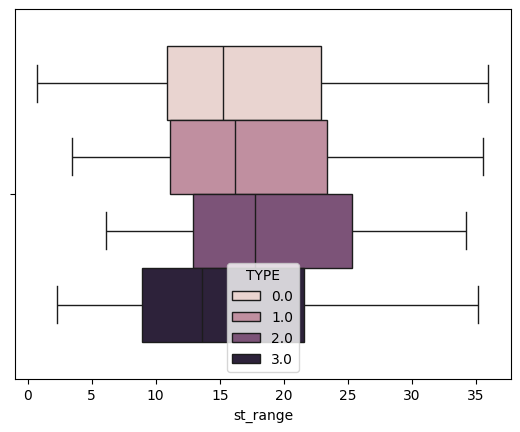

In [215]:
sns.boxplot(data=plus, x=plus["st_range"], hue = plus["TYPE"])

<Axes: xlabel='prom_slypersec', ylabel='Count'>

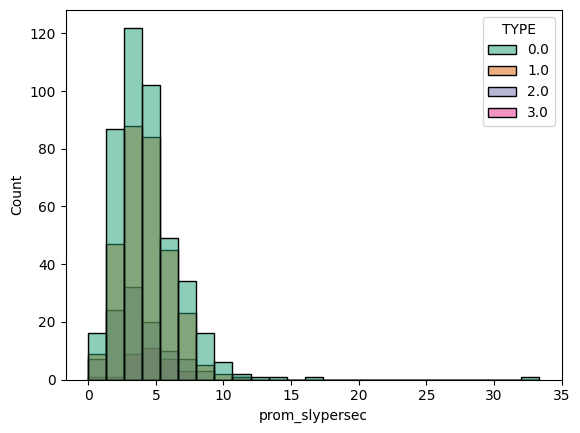

In [192]:
plus = plus[plus.prom_slypersec != 33.33]
sns.histplot(data=plus, x="prom_slypersec", hue = "TYPE", bins = 25, palette="Dark2")

<Axes: xlabel='prom_slypersec'>

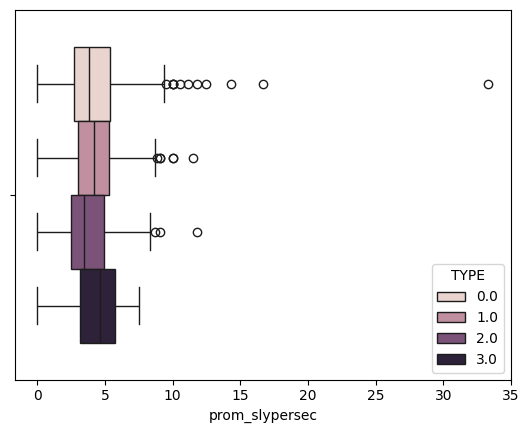

In [198]:
sns.boxplot(data=plus, x=plus["prom_slypersec"], hue = plus["TYPE"])

In [209]:
#plus = plus["TYPE"] == 1
sar = plus.loc[plus["TYPE"] == 3, "prom_slypersec"] 
sin = plus.loc[plus["TYPE"] == 2, "prom_slypersec"]
sin.mean()
#sar.mean()

np.float64(3.8498997863052065)

In [210]:
sar.mean()

np.float64(4.577260071083219)

# STATS TESTS

In [104]:
from scipy.stats import ttest_ind
t_statistic, p_value = ttest_ind(sar, sin)
# Output the results
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

ValueError: data type <class 'numpy.object_'> not inexact

#MEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEENMEEN

for idx, key in men['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"{key}.wav not found in subfolders")

        sound = parselmouth.Sound(wav_path)
        duration, meanF0, stdevF0, f0range = measurePitch(sound, 98.4, 591, "Hertz")

        plus.loc[idx, ['pitchmean', 'pitchsd', 'pitchrange', 'duration']] = [
            meanF0, stdevF0, f0range, duration
        ]

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

#WEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMENWEOMEN
for idx, key in wmen['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"{key}.wav not found in subfolders")

        sound = parselmouth.Sound(wav_path)
        duration, meanF0, stdevF0, f0range = measurePitch(sound, 170, 823, "Hertz")

        plus.loc[idx, ['pitchmean', 'pitchsd', 'pitchrange', 'duration']] = [
            meanF0, stdevF0, f0range, duration
        ]

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [ ]:
print(plus[plus['GENDER'] == 'F'].head())

In [ ]:
plus.head()

In [ ]:
sns.histplot(data=plus, x="duration", hue="Sarcasm", palette="Dark2", element='step')

In [105]:
plus = plus.drop(columns=['cmudict'])

In [106]:
dtale.show(plus)

## CAUTION: make sure split utterances dont exsist in dir before running this:

#split utterances into 3 parts
a=0
for idx, row in plus.iterrows():
    filename = row['SCENE']
    speaker = row['SPEAKER']
    fullpath = rf"C:\Users\kasia\asp2025\testy\{speaker}\{filename}.wav"
    segment_length = row['duration']
    print(segment_length)
    print(filename)
    print(speaker)
    segment_length = segment_length/3
    def split_audio(file_path, segment_length=segment_length*1000):
    # Load the audio file
        audio = AudioSegment.from_file(file_path)
    
    # Get the total length of the audio file
        total_length = len(audio)
    
    # Calculate the number of segments needed
        num_segments = 3 #this number should always be three
        print(num_segments)
    # Loop through and create each segment
        for i in range(num_segments):
            start_time = i * segment_length
            end_time = min((i + 1) * segment_length, total_length)  # Ensure the last segment does not exceed total length
            segment = audio[start_time:end_time]

        # Generate the output file name
            output_file = f"{file_path[:-4]}_part{i+1}.wav"
        
        # Export the segment as an MP3 file
            segment.export(output_file, format="wav")
            print(f"Exported: {output_file}")

    split_audio(fullpath)
    a=a+1

print(a)

In [ ]:
plus['meanf0a'] = None
plus['meanf0b'] = None
plus['meanf0c'] = None